<a href="https://colab.research.google.com/github/svtuck/rankings/blob/master/rankings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start by going in the order that USA ultimate presents the algorithm here: https://play.usaultimate.org/teams/events/rankings/

Up first is defining the score differential function.

In [0]:
import math
from collections import namedtuple

GameScore = namedtuple('GameScore', ['winning', 'losing'])
sin_p_four_pi = math.sin(.4 * math.pi)
def game_score_differential(score: GameScore) -> float:
	r = score.losing / (score.winning - 1)
	differential = 125 + 475 * math.sin(min(1, (1 - r) / .5) * .4 * math.pi) / sin_p_four_pi
	return differential

Let's spot check it. I'm assuming the round is applied AFTER the score, for the purposes of presenting the example table.

In [0]:
assert round(game_score_differential(GameScore(15, 14))) == 125
assert round(game_score_differential(GameScore(15, 5))) == 600
assert round(game_score_differential(GameScore(15, 11))) == 381
assert round(game_score_differential(GameScore(13, 9))) == 419
assert round(game_score_differential(GameScore(13, 7))) == 558
assert round(game_score_differential(GameScore(11, 9))) == 249
assert round(game_score_differential(GameScore(11, 6))) == 547

Next we define the "score weight". 

In [0]:
def score_weight(score: GameScore) -> float:
  return min(1, math.sqrt((score.winning + max(score.losing, (score.winning - 1) / 2)) / 19))

assert round(score_weight(GameScore(13,0)), 2) == 1.0
assert round(score_weight(GameScore(1,0)), 2) == .23
assert round(score_weight(GameScore(11,3)), 2) == .92
assert round(score_weight(GameScore(12,6)), 2) == .97


This looks okay, but I see at least one difference between my function and the published table, I'm going to chalk this up to rounding somewhere...

In [4]:
print(round(score_weight(GameScore(8,2)), 2) - .76)

0.020000000000000018


Finally, we need to interpret this: "The date weight depends upon how recently the game was played; games in the first week of the regular season will get a date weight of 0.5, while games in the last week of the season get a date weight of 1.0. Date weights of games in intermediate weeks are interpolated exponentially, so each week's date weight is a fixed multiple of the previous week's date weight."

There is no published formula here, so I will interpret it as best I can. If we have played N weeks, then week 1 gets a weight of .5, week N gets a weight of 1.0 and week m < N gets a weight of Nth root of 2.

.5 * factor ^ m = .5

.5 * factor ^ N = 1

factor^ N = 2 

factor = 2 ^ (1/N)

In [0]:
#Defining this constant outside, we will set this appropriately later
NUM_WEEKS = 10

def get_weighting_function():
  factor = pow(2, 1/(NUM_WEEKS - 1))
  return lambda m: .5 * pow(factor, m - 1)


assert round(get_weighting_function()(1), 2) == .5
assert round(get_weighting_function()(10), 2) == 1
NUM_WEEKS = 3
assert round(get_weighting_function()(1), 2) == .5
assert round(get_weighting_function()(3), 2) == 1

#Weights are constant factors between weeks
NUM_WEEKS = 10
assert round(get_weighting_function()(5)/get_weighting_function()(4), 2) == round(get_weighting_function()(8)/get_weighting_function()(7), 2)

Collect all calculations that are not dependent on actual ratings.

In [0]:
WeightedScore = namedtuple("WeightedScore", ['differential', 'score_weight', 'date_weight'])

def weight_score(score: GameScore, week_number: int) -> WeightedScore:
  differential = game_score_differential(score)
  s = score_weight(score)
  d = get_weighting_function()(week_number)
  return WeightedScore(round(differential), round(s,3), round(d,3))

Now we have our scoring functions defined, and we can move on to read in our data, downloaded from https://www.usaultimate.org/college/#Rankings



In [7]:
import csv
games = []

# We will use "ids" and map back when we display something
name_dictionary = {}
with open('games.csv') as csvfile:
  game_reader = csv.DictReader(csvfile)
  for row in game_reader:
    try:
      team_1_score = int(row['Team 1 Score'])
      team_2_score = int(row['Team 2 Score'])
      games.append(row)
      name_dictionary[row['Team 1 ID']] = row['School Name 1+Team Designation']
      name_dictionary[row['Team 2 ID']] = row['School Name 2+Team Designation']
    except ValueError as e:
      pass

print(len(games))

2582


Now we can precalculate weights and differentials

In [8]:
from collections import defaultdict
from datetime import datetime
from dateutil.parser import parse

start_date = datetime.max
end_date = datetime.min
for game in games:
  d = parse(game['Game Date'])
  if d < start_date:
    start_date = d
  if d > end_date:
    end_date = d

NUM_WEEKS = int((end_date - start_date).days / 7 + 1)


def games_to_scores(games):
  weighted_scores = defaultdict(list)
  for game in games:
    try: 
      #We are calling the first week, 'week 1'
      week_number =  int((parse(game['Game Date']) - start_date).days / 7 + 1)
      team_1_score = int(game['Team 1 Score'])
      team_2_score = int(game['Team 2 Score'])

      score = GameScore(max(team_1_score, team_2_score), min(team_1_score, team_2_score))
      weights = weight_score(score, week_number)
      loser_weights = WeightedScore(-1 * weights.differential , weights.score_weight, weights.date_weight)
      if (team_1_score >= team_2_score):
        winner = game['Team 1 ID']
        loser = game['Team 2 ID']
      else:
        winner = game['Team 2 ID']
        loser = game['Team 1 ID']

      weighted_scores[winner].append((weights, loser))
      weighted_scores[loser].append((loser_weights, winner))

    except ValueError as e:
      # Throw out L/W/F... no defined way of handling them
      pass
  return weighted_scores
weighted_scores = games_to_scores(games)
print(len(weighted_scores))  



422


Let's spot check some, say: Oregon (19693), and Puget Sound (20039) and verify that all differentials sum to 0.

In [9]:

print(sum(x[0].differential > 0 for x in weighted_scores["19693"]), sum(x[0].differential < 0 for x in weighted_scores["19693"]))
print(sum(x[0].differential > 0 for x in weighted_scores["20039"]), sum(x[0].differential < 0 for x in weighted_scores["20039"]))

14 5
12 4


In [0]:
assert sum([x[0].differential for i in weighted_scores for x in weighted_scores[i] ]) == 0

Now let's run the the rankings

In [11]:
def new_rating(team_id, ratings, scores):
  scores = scores[team_id]
  numerator = [(ratings[opponent_id] + weights.differential) * weights.score_weight * weights.date_weight for (weights, opponent_id) in scores]
  denominator = [weights.score_weight * weights.date_weight for (weights, _) in scores]
  return sum(numerator) / sum(denominator)

def rank(scores):
  
  ratings = {i: 1000 for i in scores}
  for r in range(100):
    new_ratings = {i: new_rating(i, ratings, scores) for i in ratings.keys()}
    ratings = new_ratings
  return ratings

def top_n(n, ratings):
  return sorted([(ratings[i], name_dictionary[i]) for i in ratings], reverse=True)[:n]

def print_top_n(n, ratings):
  t = top_n(n, ratings)
  for x in t:
    print(x[1], round(x[0]))
    



print_top_n(20, rank(weighted_scores))

  

Brown 2075
North Carolina 2050
Pittsburgh 2033
Oregon 2025
Brigham Young 1964
Cal Poly-SLO 1964
Carleton College-CUT 1962
Colorado 1940
Massachusetts 1904
North Carolina State 1879
Wisconsin 1869
Washington 1865
Southern California 1844
Texas 1844
Central Florida 1835
Ohio State 1834
Minnesota 1796
Michigan 1743
Tufts 1740
Colorado State 1737


Looks about right. There are a couple of special edge cases I haven't included, but I think this is safe to call a correct implementation of the algorithm. Now let's try to evaluate it.

First lets look at distribution of ratings.


(array([ 3.,  2.,  3., 11.,  7., 23., 28., 40., 33., 41., 43., 46., 32.,
        35., 21., 20., 14.,  4.,  9.,  7.]),
 array([-478.78100003, -351.0868406 , -223.39268117,  -95.69852173,
          31.9956377 ,  159.68979713,  287.38395656,  415.07811599,
         542.77227543,  670.46643486,  798.16059429,  925.85475372,
        1053.54891315, 1181.24307258, 1308.93723202, 1436.63139145,
        1564.32555088, 1692.01971031, 1819.71386974, 1947.40802918,
        2075.10218861]),
 <a list of 20 Patch objects>)

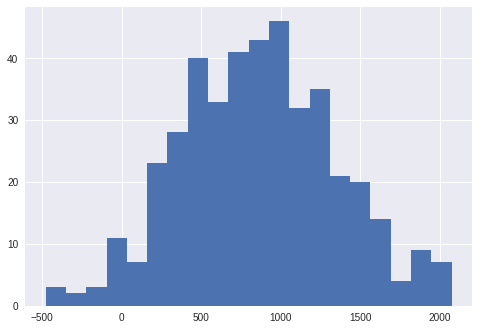

In [12]:
import matplotlib.pyplot as plt
ratings = rank(weighted_scores)
plt.hist([ratings[i] for i in ratings], bins=20)

That jives with what we would expect. Next lets explore how predictive the ratings are. To do this, we'll train a logistic regression model on the rating differentials and results.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


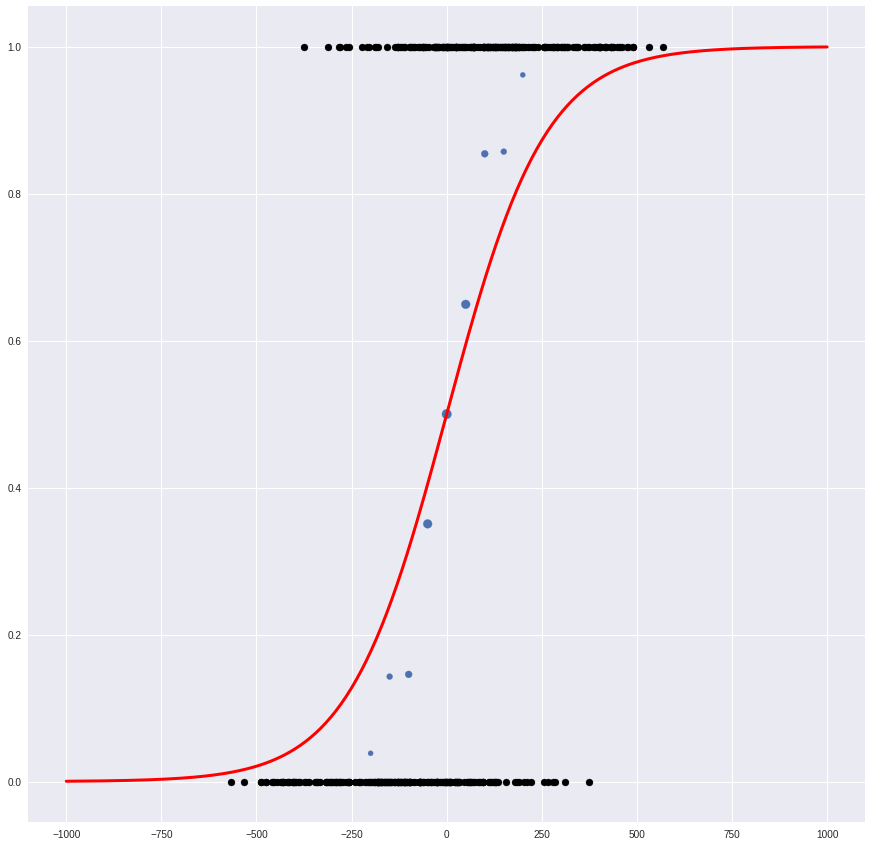

In [13]:
from sklearn import linear_model
import numpy as np

def viz_differentials(ratings, scores):
  rating_differentials = []
  results = []
  for team in scores:
    for game in scores[team]:
      results.append( 1 if game[0].differential > 0 else 0)
      rating_differentials.append(ratings[team] - ratings[game[1]])
  X = np.reshape(rating_differentials, (-1, 1))
  y = np.reshape(results, (-1, 1))
  clf = linear_model.LogisticRegression(solver='lbfgs')
  clf.fit(X, y)
  plt.figure(1, figsize=(15, 15))
  plt.clf()
  plt.scatter(X.ravel(), y, color='black', zorder=20)
  X_test = np.linspace(-1000, 1000, 300)
  def model(x):
    return 1 / (1 + np.exp(-x))

  loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
  plt.plot(X_test, loss, color='red', linewidth=3)

  binned = defaultdict(list)
  for (differential, result) in zip(rating_differentials, results):
    binned[50 * round(differential/100)].append(result)
  x = []
  y = []
  area = []
  for i in binned:
    x.append(i)
    y.append(sum(binned[i])/len(binned[i]))
    area.append(len(binned[i]))
  plt.scatter(x,y,s=area)


def explore(scores):
  ratings = rank(scores)
  viz_differentials(ratings, scores)
  plt.figure(1)
  threshold = sorted([ratings[i] for i in ratings])[int(len(ratings)* .9)]
  top_games = defaultdict(list)
  for team in scores:
    if ratings[team] > threshold:
      for game in scores[team]:
        if ratings[game[1]] > threshold:
          top_games[team].append(game)
    
  viz_differentials(ratings, top_games)
  
      
explore(weighted_scores)
    
  

So we have reasonably confident (>80%) predictions when ratings are more than about 100 points different. Finally, I wanted to run a cross validation on the algorithm. To do that, we with withhold 10% of games, rerank, and then use the resulting rankings to predict the winners of the held out games.

In [14]:
import random

def evaluate(games):
  random.shuffle(games)
  sample_size = int(len(games) / 10)
  test = games[:sample_size]
  train = games[sample_size:]
  
  scores = games_to_scores(train)
  ranks = rank(scores)
  avg = sum([ranks[i] for i in ranks])/len(ranks)

  results = [(ranks.get(game['Team 1 ID'], avg) > ranks.get(game['Team 2 ID'], avg)) == (int(game['Team 1 Score']) > int(game['Team 2 Score'])) for game in test]
  return sum(results)/len(results)


results = [evaluate(games) for i in range(30)]
print(results)
print(sum(results)/len(results))

[0.7945736434108527, 0.748062015503876, 0.7945736434108527, 0.7674418604651163, 0.7829457364341085, 0.748062015503876, 0.8217054263565892, 0.751937984496124, 0.7868217054263565, 0.7868217054263565, 0.7790697674418605, 0.7713178294573644, 0.7558139534883721, 0.7868217054263565, 0.7751937984496124, 0.7945736434108527, 0.7790697674418605, 0.7596899224806202, 0.7945736434108527, 0.7984496124031008, 0.7558139534883721, 0.748062015503876, 0.7868217054263565, 0.7751937984496124, 0.7441860465116279, 0.7674418604651163, 0.7868217054263565, 0.7441860465116279, 0.7751937984496124, 0.7364341085271318]
0.7732558139534885


We are looking at roughly 25% of all games as upsets according to our algorithm. It'd be interesting to know if this is better or worse at the top. So we will repeat this but only evaluate against the top 10% of teams.



In [15]:
def evaluate_top_k(games, k):
  random.shuffle(games)
  sample_size = int(len(games) / 10)
  test = games[:sample_size]
  train = games[sample_size:]
  
  scores = games_to_scores(train)
  ranks = rank(scores)
  
  avg = sum([ranks[i] for i in ranks])/len(ranks)
  threshold = sorted([ranks[i] for i in ranks])[int(len(ranks)* k)]
  
  top_games = list(filter(lambda game: (ranks.get(game['Team 1 ID'], avg) > threshold and ranks.get(game['Team 2 ID'], avg) > threshold), test))
  results = [(ranks.get(game['Team 1 ID'], avg) > ranks.get(game['Team 2 ID'], avg)) == (int(game['Team 1 Score']) > int(game['Team 2 Score'])) for game in top_games]
  return sum(results)/len(results)


results = [evaluate_top_k(games, .9) for i in range(30)]
print(results)
print(sum(results)/len(results))

[0.5925925925925926, 0.5384615384615384, 0.5882352941176471, 0.64, 0.8461538461538461, 0.7142857142857143, 0.7727272727272727, 0.625, 0.84375, 0.6818181818181818, 0.55, 0.7083333333333334, 0.8, 0.9, 0.6, 0.76, 0.6666666666666666, 0.8333333333333334, 0.7619047619047619, 0.8846153846153846, 0.7272727272727273, 0.8260869565217391, 0.5714285714285714, 0.6551724137931034, 0.76, 0.8571428571428571, 0.782608695652174, 0.92, 0.7368421052631579, 0.9473684210526315]
0.7363933556045746


This says that pure rankings are perhaps a little worse at the top than they are in the entire population, but only slightly and not confidently.

Finally let's look at that slice of data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


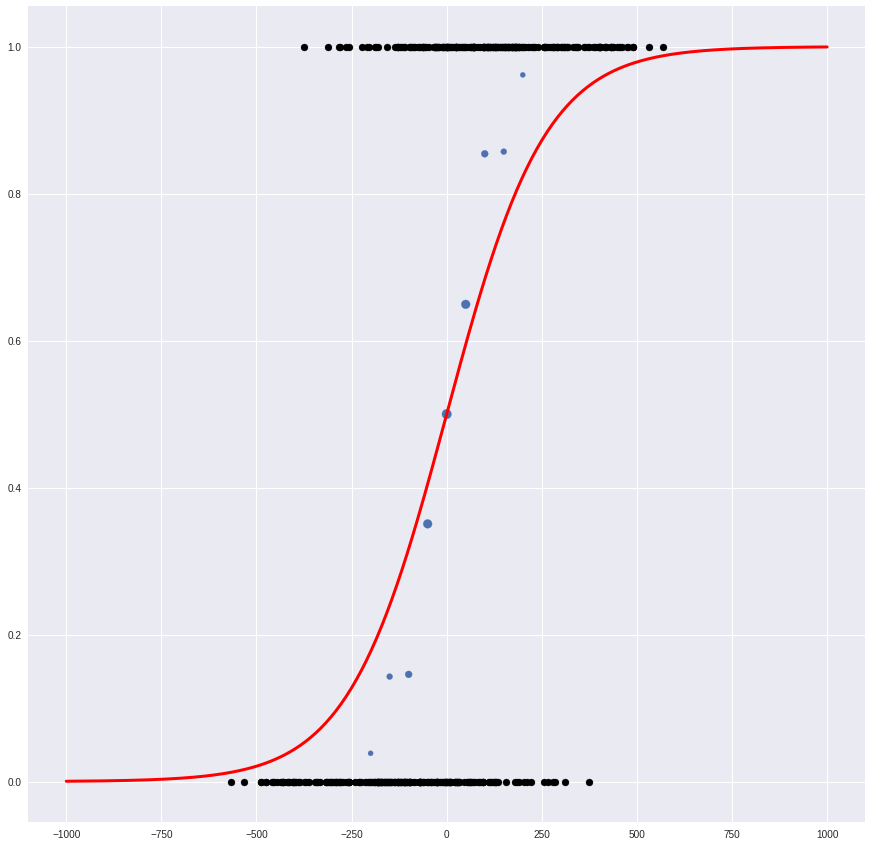

In [16]:
def explore_top(scores):
  ratings = rank(scores)

  threshold = sorted([ratings[i] for i in ratings])[int(len(ratings)* .9)]
  top_games = defaultdict(list)
  for team in scores:
    if ratings[team] > threshold:
      for game in scores[team]:
        if ratings[game[1]] > threshold:
          top_games[team].append(game)
    
  viz_differentials(ratings, top_games)
explore_top(weighted_scores)